In [22]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [23]:
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [24]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

dev_data = data[0:1000].T
Y_dev = dev_data[0]
X_dev = dev_data[1:n]
X_dev = X_dev / 255.
X_dev = X_dev.astype(np.float32)

train_data = data[1000:m].T
Y_train = train_data[0]
X_train = train_data[1:n]
X_train = X_train / 255.
X_train = X_train.astype(np.float32)
_, m_train = X_train.shape

In [26]:
X_dev[:, 0].shape

(784,)

In [36]:
def init_params():
    input_size = 784
    hidden_size = 512
    num_classes = 10
    
    W1 = np.random.randn(hidden_size, input_size) * np.sqrt(2.0 / input_size)
    b1 = np.zeros((hidden_size, 1))
    W2 = np.random.randn(num_classes, hidden_size) * np.sqrt(2.0 / hidden_size)
    b2 = np.zeros((num_classes, 1))
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(0, Z)

def softmax(Z):
    Z_shift = Z - np.max(Z, axis = 0, keepdims = True)
    expZ = np.exp(Z_shift)
    return expZ / np.sum(expZ, axis = 0, keepdims = True)

def compute_loss(A2, Y):
    m = Y.size
    one_hot_Y = one_hot(Y, num_classes = 10)
    eps = 1e-12
    A2_clipped = np.clip(A2, eps, 1 - eps)
    return -1 / m * np.sum(one_hot_Y * np.log(A2_clipped))
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def one_hot(Y, num_classes = 10):
    m = Y.size
    one_hot_Y = np.zeros((num_classes, m))
    one_hot_Y[Y, np.arange(m)] = 1
    return one_hot_Y

def deriv_ReLU(Z):
    return Z > 0

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y): 
    m = Y.size
    one_hot_Y = one_hot(Y, num_classes = 10)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis = 1, keepdims = True)
    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis = 1, keepdims = True)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2 ,db2, alpha):
    W1 -= alpha * dW1
    b1 -= alpha * db1
    W2 -= alpha * dW2
    b2 -= alpha * db2
    return W1, b1, W2, b2

In [37]:
def get_predictions(A2):
    return np.argmax(A2, axis = 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, iterations, alpha, X_dev = None, Y_dev = None):
    W1, b1, W2, b2 = init_params()
    best_W1, best_b1, best_W2, best_b2 = W1.copy(), b1.copy(), W2.copy(), b2.copy()
    best_dev_acc = 0.0

    for i in range(iterations):
            Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
            dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
            W1, b1, W2, b2  = update_params(W1, b1, W2, b2, dW1, db1, dW2 ,db2, alpha)
    
            if i > 0 and i % 200 == 0:
                alpha *= 0.5
            
            if (i % 20 == 0):
                loss = compute_loss(A2, Y)
                acc = get_accuracy(get_predictions(A2), Y)
    
                if X_dev is not None and Y_dev is not None:
                    _, _, _, A2_dev = forward_prop(W1, b1, W2, b2, X_dev)
                    dev_acc = get_accuracy(get_predictions(A2_dev), Y_dev)
    
                    if dev_acc > best_dev_acc:
                        best_dev_acc = dev_acc
                        best_W1, best_b1 = W1.copy(), b1.copy()
                        best_W2, best_b2 = W2.copy(), b2.copy()
                
                    print(f'iterations: {i} | loss {loss:.4f} | train {acc:.4f} | dev {dev_acc:.4f}')
    
                else:
                    print(f'iterations: {i} | loss {loss:.4f} | train {acc:.4f}')
    
    if X_dev is not None and Y_dev is not None:
        return best_W1, best_b1, best_W2, best_b2
    return W1, b1, W2, b2

def gradient_descent_minibatch(
    X, 
    Y, 
    epochs, 
    alpha, 
    batch_size = 64,
    X_dev = None,
    Y_dev = None
):
    W1, b1, W2, b2 = init_params()
    best_W1, best_b1, best_W2, best_b2 = W1.copy(), b1.copy(), W2.copy(), b2.copy()
    best_dev_acc = 0.0

    m = X.shape[1]

    for epoch in range(epochs):
        permutation = np.random.permutation(m)
        X_shuffled = X[:, permutation]
        Y_shuffled = Y[permutation]

        for i in range(0, m, batch_size):
            X_batch = X_shuffled[:, i:i + batch_size]
            Y_batch = Y_shuffled[i:i + batch_size]

            Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X_batch)
            dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X_batch, Y_batch)
            W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)

        if epoch > 0 and epoch % 5 == 0:
            alpha *= 0.5

        _, _, _, A2_train = forward_prop(W1, b1, W2, b2, X)
        train_loss = compute_loss(A2_train, Y)
        train_acc = get_accuracy(get_predictions(A2_train), Y)

        if X_dev is not None and Y_dev is not None:
            _, _, _, A2_dev = forward_prop(W1, b1, W2, b2, X_dev)
            dev_acc = get_accuracy(get_predictions(A2_dev), Y_dev)

            if dev_acc > best_dev_acc:
                best_dev_acc = dev_acc
                best_W1, best_b1 = W1.copy(), b1.copy()
                best_W2, best_b2 = W2.copy(), b2.copy()

            print(f'epoch: {epoch} | loss {train_loss:.4f}|'
                 f'train: {train_acc:.4f} | dev {dev_acc:.4f}'
            )

        else:
            print(f'epoch: {epoch} | loss {train_loss:.4f} | train {train_acc:.4f}')

    if X_dev is not None and Y_dev is not None:
        return best_W1, best_b1, best_W2, best_b2
    return W1, b1, W2, b2


            

In [38]:
W1, b1, W2, b2 = gradient_descent_minibatch(
    X_train,
    Y_train,
    epochs = 15,
    alpha = 0.1,
    batch_size = 64,
    X_dev = X_dev,
    Y_dev = Y_dev
)

epoch: 0 | loss 0.2448|train: 0.9294 | dev 0.9260
epoch: 1 | loss 0.1695|train: 0.9520 | dev 0.9450
epoch: 2 | loss 0.1316|train: 0.9644 | dev 0.9570
epoch: 3 | loss 0.1085|train: 0.9708 | dev 0.9620
epoch: 4 | loss 0.0918|train: 0.9759 | dev 0.9670
epoch: 5 | loss 0.0763|train: 0.9804 | dev 0.9710
epoch: 6 | loss 0.0713|train: 0.9822 | dev 0.9710
epoch: 7 | loss 0.0646|train: 0.9837 | dev 0.9710
epoch: 8 | loss 0.0607|train: 0.9848 | dev 0.9740
epoch: 9 | loss 0.0572|train: 0.9858 | dev 0.9760
epoch: 10 | loss 0.0539|train: 0.9866 | dev 0.9750
epoch: 11 | loss 0.0514|train: 0.9876 | dev 0.9790
epoch: 12 | loss 0.0499|train: 0.9880 | dev 0.9750
epoch: 13 | loss 0.0479|train: 0.9888 | dev 0.9760
epoch: 14 | loss 0.0466|train: 0.9894 | dev 0.9770


In [39]:
_, _, _, A2_train = forward_prop(W1, b1, W2, b2, X_train)
train_acc = get_accuracy(get_predictions(A2_train), Y_train)
print("TRAIN acc:", train_acc)

_, _, _, A2_dev = forward_prop(W1, b1, W2, b2, X_dev)
dev_acc = get_accuracy(get_predictions(A2_dev), Y_dev)
print("DEV acc:", dev_acc)

TRAIN acc: 0.9875609756097561
DEV acc: 0.979


In [40]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    return get_predictions(A2)

def test_predictions(index, W1, b1, W2, b2):
    x = X_train[:, index, None]
    pred = make_predictions(x, W1, b1, W2, b2)
    true_label = Y_train[index]
    
    print('prediction: ', pred.item())
    print('label: ', true_label)

    img = x.reshape(28, 28) * 255
    plt.gray()
    plt.imshow(img, interpolation = 'nearest')
    plt.show()

    return img

prediction:  7
label:  7


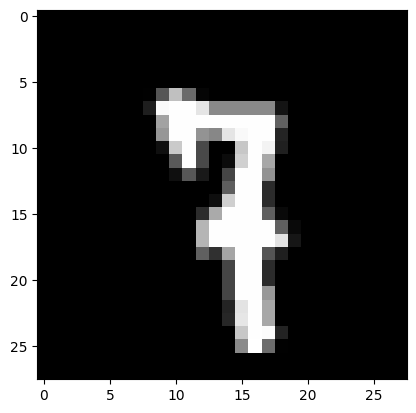

prediction:  0
label:  0


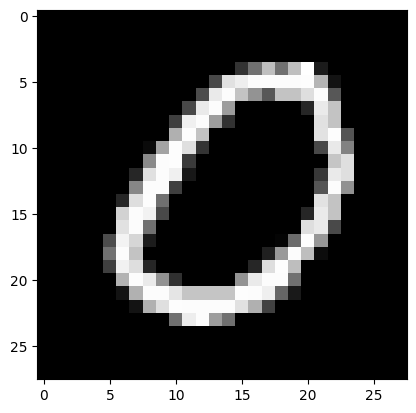

prediction:  3
label:  3


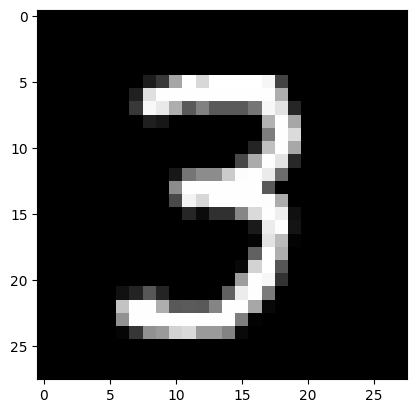

prediction:  7
label:  7


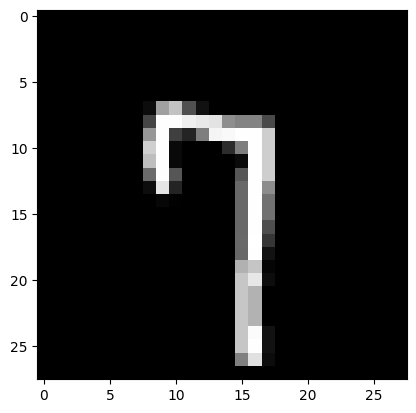

In [41]:
image = test_predictions(11, W1, b1, W2, b2)
image = test_predictions(0, W1, b1, W2, b2)
image = test_predictions(57, W1, b1, W2, b2)
image = test_predictions(456, W1, b1, W2, b2)